# MTH 9894 Algo Trading - ODR Pairs Trading

- `Weiyi Chen, weiyi.chen@baruchmail.cuny.edu`
- `Jingjing Jia, abundzujj@gmail.com`
- `Jingqiu He, jingqiu.he@baruchmail.cuny.edu`

## Overview

- Strategy review: Pairs Trading
  - Principle
  - Model
  - Assumption

- Improvements: what we change/improve
  - Replicate Paper Result
  - Three improvements
  
- Final Results
  - Result
  - Analysis

- Data: the source of data, universe and data span

- Reference: white paper that is used as a basis

## 1. Strategy: ODR Pairs Trading

### 1.1 Principle

- Find divergences of highly correlated pairs
- Make money when they converge

<img src="CSCO-APD.png" width=600px>

<center>*Source: Google Finance*</center> 

- Market neutral, so works in bearish markets as well as bullish markets.

<img src="CSCO-APD-Down.png" width=600px>

### 1.2 Method
*Example: CSCO and APD*

#### 1.2.1 Identify Pairs

1. Calculate correlation of returns
2. Find highly correlated pairs
3. Find best fit line and average and standard deviation of distances from line

<img src="find-pairs.png" width=600px>

#### 1.2.2 Select Pairs

1. Generate residual spread (distance from best fit line)
2. Select pairs with more crossings and larger standard deviation

<img src="select-pairs.png" width=600px>

#### 1.2.3 Trade Pairs

- Entry: residual spread reaches ±1.0 std
- Exit: residual spread crosses 0.0

<img src='trade-pair.png' width=600px>

- Holding period: exit after 20 trading days

<img src='holding.png' width=600px>

### 1.3 Assumptions and Details 

Answer questions from email

#### 1.3.1 How to choose pairs?

As indicated in `1.2.1 Find Pairs`,

In [ ]:
for trading_day in backtest_days:
    for equity_1 in equity_universe:
        for equity_2 in equity_universe:
        
            # calculate correlation of last 252 daily returns from given trading day
            corr = cal_corr(equity_1, equity_2, trading_day, lookback_period = 252) 
            
            if corr < 0.97: continue
            else: save_to_database(trading_day, equity_1, equity_2, corr)

As indicated in `1.2.2 Select Pairs` (one of our improvement),

In [ ]:
for trading_day in backtest_days:
    
    # a dataframe of pairs info
    pairs = access_pairs_from_database(trading_day)
    
    # calculate residue properties of pairs, i.e. last day residue, number of crossings, residue std
    pairs = cal_residue(pairs)
    
    # find triggered pairs, last day residue > residue std
    pairs_triggered = find_trigger_pairs(pairs)
    
    # sort and rank
    pairs_triggered.sort(['number of crossings','residue std'])

#### 1.3.2 How to allocate money per pair (backtest setting)

In [ ]:
c_strat = lrlbtr.LrlStratConfig(
        f_value=10000000.0,
        dt_start=dt_start,
        dt_end=dt_end,
        s_name='Pairs Trade Backtest',
        s_display_name='ODR Pairs Trading',
        s_benchmark='$SPX',
        s_benchmark_name='S&P 500',
        d_sell_on_target_args={'i_holding_period': 20.0,
                               'b_event': True},

        fc_alloc=lrls.alloc_event_pairs_backtest,
    
        d_alloc_args={'ddt_lt_syms':ddt_lt_syms,             # Dictionary of pairs_triggered
                    'f_cash_cent':0.15,                      # Percent cash allocated to each event
                    'i_max_equities':1.0,                    # Max equites to trade at one trading day
                    'f_core_weight':1.0},

        d_sim_args={'f_slippage':0.0005,
                    'f_minimumcommision':2.95,
                    'f_commision_share':0.0035,
                    'i_target_leverage':1.,
                    'f_borrow_rate':0.035})

#### 1.3.3  Conditions to get in and get out

As indicated in `1.2.3 Trade Pairs`,

- Entry: residual spread crosses out of ±1.0 std
- Exit_1: residual spread crosses 0.0 (make money)
- Exit_2: after 20 trading days (possibly lose money)

<img src='holding.png' width=600px>

## 2. Improvement

### 2.1 Replicate paper result

#### Performance 

```
- Benchmark: S&P500
- Return:        -3.26% (fund)     vs. 24.44% (benchmark)
- Sharpe ratio:  -0.03  (fund)     vs. 0.27   (benchmark)
- Sortino ratio: -0.04  (fund)     vs. 0.34   (benchmark)
- Max DrawDown:  -20.88%(fund)     vs. -53.25%(benchmark)
```

<img src='replication.png' width=900px>

#### Backtest setting

- 6-year backtest from 1/1/2008 to 12/31/2013
- Slippage each direction: 5bps
- Short interest: 3.5%
- Commisions: 2.95 per Trade
- Allocation per Event: 15%

If there is no transaction cost, 

<img src='no-transaction.png' width=900px>


### 2.2 Improvements & Results

- Select pairs with a higher frequency of price convergence, in order to derive higher chances of future convergence;

<img src='most-correlated.png' width=900px>

    - Return:         -3.26% --> 28.98% (fund) vs. 24.44% (benchmark)
    - Sharpe ratio:   -0.03  --> 0.59   (fund) vs. 0.27   (benchmark)
    - Sortino ratio:  -0.04  --> 0.78   (fund) vs. 0.34   (benchmark)
    - Max DrawDown:  -20.88% --> -13.00%(fund) vs. -53.25%(benchmark)

- Decrease the divergence restriction to trigger more trading events which increase trading frequencies, and apply Machine Learning algorithm to train a prediction learner

  - change correlation shrehold from .97 to .90 (have more events triggered)
  - apply *SVM* algo to train a learner 
    - input: crossing_freqency, residue std
    - output: returns at exit
  - use learner to select today's pairs to trade

<img src='event_study1.png' width=600px> 
<center> Original </center>

<img src='event_study2.png' width=600px>
<center> Modified </center>

<img src='newest.png' width=900px>

    - Return:         -3.26% --> 28.98% --> 59.29% (fund) vs. 24.44% (benchmark)
    - Sharpe ratio:   -0.03  --> 0.59   --> 1.01   (fund) vs. 0.27   (benchmark)
    - Sortino ratio:  -0.04  --> 0.78   --> 1.37   (fund) vs. 0.34   (benchmark)
    - Max DrawDown:  -20.88% --> -13.00%--> -4.02% (fund) vs. -53.25%(benchmark)

- Further Improvement: Increase the pairs dimension from two to multiple, which largely expands the number of potential portfolios to be traded to satisfy strict selection criteria. (takes more than 24hrs to run, so just 2 years backtesting)

<img src='odr.png' width=900px>
<center> ODR Backtest 2008 - 2009 </center>

<img src='fft.png' width=900px>
<center> Fast Fourier Transform Backtest 2008 - 2009 </center>

## 3. Results with Analysis

<img src='odr.png' width=900px>

### 3.1 Summary

```
Overall Summary
    Start Date:                2008-01-03
    End Date:                  2009-12-31
    Number of Used Symbols:    242
    Number of Missing Symbols: 0 
    Maximum Event Value:       1.000
    Minimum Event Value:      -1.000
    Number of Events:          123506

Bin Summary
                                  Bin 0       Bin 1
    Total Number of Events:       32103       31943
    Average Events per Year:      12202.05    12141.23
    Average Positions per Day:    2565.15     2552.37
    Minimum Event Value:         -1.000       1.000
    Maximum Event Value:         -1.000       1.000

Direction 
                                  Long        Short
    Maximum Return                0.72%       5.26%
    Day of Maximum Return         61          61
    Maximum Sharpe Ratio          1.48        9.58
    Day of Max. Sharpe Ratio      60          60
    Return at Max. Sharpe Ratio   0.72%       5.26%
    Stdev. at Max. Sharpe Ratio   7.75%       8.72
```

### 3.2 Most Profitable Pairs

Most correlated pairs:
<img src='most_correlated.png' width=600px>

Most profitable pairs:
<img src='most_profitable.png' width=600px>

### 3.3 Exposure

<img src='exposure.png' width=900px>

### 3.4 Risk/Return

<img src='risk_return.png' width=900px>

### 3.5 Monthly Returns

<img src='monthly_returns.png' width=1000px>

## 4. Reference


- Balch, Tucker; Chen, Weiyi. *Quantitative Tools: What Wealth Managers Need to Know.* Trading with Correlated Pairs, 2013.
<img src="PairsTradingWhitepaper.png" border="5" width=300px>


- Vidyamurthy, Ganapathy. *Pairs Trading: quantitative methods and analysis.* Vol. 217. John Wiley & Sons, 2004.
<img src="reference.png" width=300px>

## 5. Data and Implementation

### 5.1 Source

Local database, *Yahoo Finance*

In [12]:
# QSTK Imports
import QSTK.qstkutil.qsdateutil as du
import QSTK.qstkutil.tsutil as tsu
import QSTK.qstkutil.DataAccess as da

# Third Party Imports
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd

# List of symbols
ls_symbols = ["AAPL", "GLD", "$SPX", "XOM"]

# Start and End date of the charts
dt_start = dt.datetime(2006, 1, 1)
dt_end = dt.datetime(2010, 12, 31)

# We need closing prices so the timestamp should be hours=16.
dt_timeofday = dt.timedelta(hours=16)

# Get a list of trading days between the start and the end.
ldt_timestamps = du.getNYSEdays(dt_start, dt_end, dt_timeofday)

# Creating an object of the dataaccess class with Yahoo as the source.
c_dataobj = da.DataAccess('Yahoo')

# Keys to be read from the data, it is good to read everything in one go.
ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']

# Reading the data, now d_data is a dictionary with the keys above.
# Timestamps and symbols are the ones that were specified before.
ldf_data = c_dataobj.get_data(ldt_timestamps, ls_symbols, ls_keys)
d_data = dict(zip(ls_keys, ldf_data))

print d_data['close']

                      AAPL        GLD     $SPX    XOM
2006-01-03 16:00:00  10.07   53.12000  1268.80  47.13
2006-01-04 16:00:00  10.10   53.30000  1273.46  47.21
2006-01-05 16:00:00  10.02   52.34000  1273.48  46.97
2006-01-06 16:00:00  10.28   53.72000  1285.45  47.90
2006-01-09 16:00:00  10.25   54.60000  1290.15  47.87
2006-01-10 16:00:00  10.90   54.06000  1289.69  48.25
2006-01-11 16:00:00  11.31   54.53000  1294.18  48.58
2006-01-12 16:00:00  11.36   54.43000  1286.06  48.07
2006-01-13 16:00:00  11.53   55.44000  1287.61  49.14
2006-01-17 16:00:00  11.41   55.26000  1282.93  49.60
2006-01-18 16:00:00  11.12   54.07000  1277.93  48.91
2006-01-19 16:00:00  10.65   55.59000  1285.04  49.57
2006-01-20 16:00:00  10.25   55.20000  1261.49  48.79
2006-01-23 16:00:00  10.47   55.77000  1263.82  49.33
2006-01-24 16:00:00  10.25   55.73000  1266.86  49.13
2006-01-25 16:00:00  10.00   56.14000  1264.68  48.53
2006-01-26 16:00:00   9.75   55.88000  1273.83  48.32
2006-01-27 16:00:00   9.71  

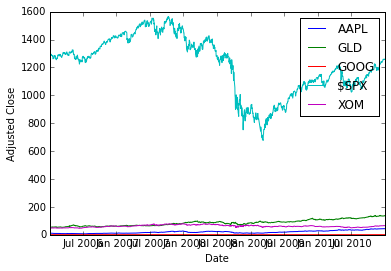

In [5]:
%matplotlib inline

# Getting the numpy ndarray of close prices.
na_price = d_data['close'].values

# Plotting the prices with x-axis=timestamps
plt.clf()
plt.plot(ldt_timestamps, na_price)
plt.legend(ls_symbols)
plt.ylabel('Adjusted Close')
plt.xlabel('Date')
plt.show()

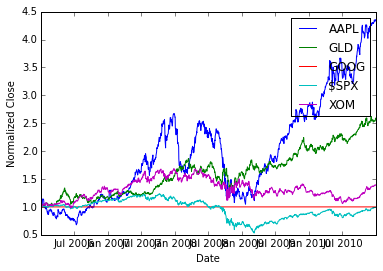

In [6]:
# Normalizing the prices to start at 1 and see relative returns
na_normalized_price = na_price / na_price[0, :]

# Plotting the prices with x-axis=timestamps
plt.clf()
plt.plot(ldt_timestamps, na_normalized_price)
plt.legend(ls_symbols)
plt.ylabel('Normalized Close')
plt.xlabel('Date')
plt.show()

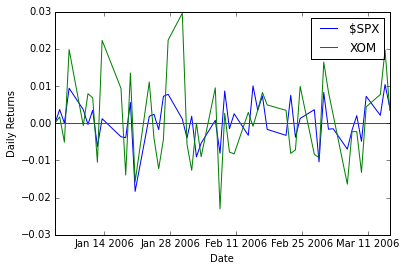

In [7]:
# Copy the normalized prices to a new ndarry to find returns.
na_rets = na_normalized_price.copy()

# Calculate the daily returns of the prices. (Inplace calculation)
# returnize0 works on ndarray and not dataframes.
tsu.returnize0(na_rets)

# Plotting the plot of daily returns
plt.clf()
plt.plot(ldt_timestamps[0:50], na_rets[0:50, 3])  # $SPX 50 days
plt.plot(ldt_timestamps[0:50], na_rets[0:50, 4])  # XOM 50 days
plt.axhline(y=0, color='r')
plt.legend(['$SPX', 'XOM'])
plt.ylabel('Daily Returns')
plt.xlabel('Date')
plt.show()

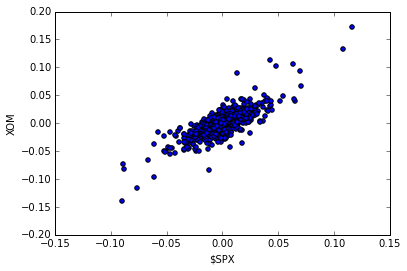

In [8]:
# Plotting the scatter plot of daily returns between XOM VS $SPX
plt.clf()
plt.scatter(na_rets[:, 3], na_rets[:, 4], c='blue')
plt.ylabel('XOM')
plt.xlabel('$SPX')
plt.show()

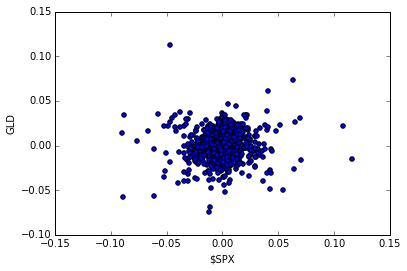

In [10]:
# Plotting the scatter plot of daily returns between $SPX VS GLD
plt.clf()
plt.scatter(na_rets[:, 3], na_rets[:, 1], c='blue')  # $SPX v GLD
plt.ylabel('GLD')
plt.xlabel('$SPX')
plt.show()

## 5.2 Universe

(avoid survival bias)
1. equities in the list of S&P500-2008
2. equities in the list of S&P500-2012

In [4]:
# QSTK Imports
import QSTK.qstkutil.qsdateutil as du
import QSTK.qstkutil.tsutil as tsu
import QSTK.qstkutil.DataAccess as da

# Third Party Imports
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd


# Creating an object of DataAccess Class
c_dataobj = da.DataAccess('Yahoo')

# Getting a list of symbols from Lists
# Lists : S&P5002012, S&P5002008, Index
ls_symbols_2012 = c_dataobj.get_symbols_from_list('sp5002012')
ls_symbols_2008 = c_dataobj.get_symbols_from_list('sp5002008')
print [item for item in ls_symbols_2008 if item not in ls_symbols_2012]

['FMCC', 'FNMA', 'ABI', 'ABKFQ', 'ACAS', 'ACS', 'ASH', 'AYE', 'BC', 'BDK', 'BJS', 'BRLI', 'BSC', 'BUD', 'CBSH', 'CCMO', 'CEG', 'CFC+A', 'CIEN', 'CIT', 'CPWR', 'CTX', 'CVG', 'DDR', 'DDS', 'DYN', 'EDS', 'EK', 'EP', 'EQ', 'ERTS', 'GENZ', 'GGP', 'GM', 'GR', 'IACI', 'ITT', 'JAVA', 'JNS', 'JNY', 'KBH', 'KG', 'LEHMQ', 'LIZ', 'MBI', 'MDP', 'MHS', 'MI', 'MIL', 'MTG', 'MTW', 'MWW', 'NCC', 'NOVL', 'NSM', 'NVLS', 'NYT', 'ODP', 'OMX', 'PBG', 'PGN', 'PTV', 'Q', 'QLGC', 'RIG', 'ROH', 'RSH', 'SAF', 'SGP', 'SII', 'SLE', 'SNV', 'SSP', 'STR', 'SVU', 'TEX', 'TLAB', 'UIS', 'UST', 'VIA.B', 'WAMUQ', 'WB', 'WEN', 'WFR', 'WFT', 'WWY', 'WYE', 'XTO']
